Filtered out 81 CpGs with all zero methylation fractions


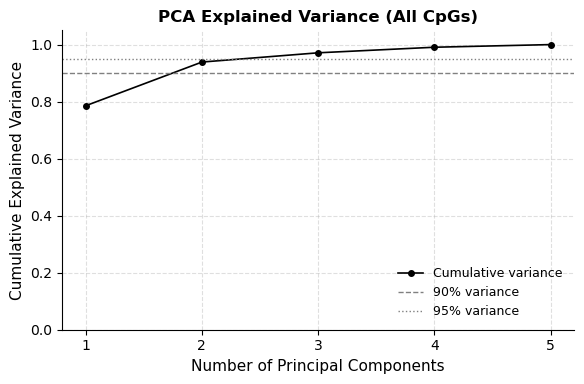

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# === Load data ===
df = pd.read_csv("cpgs_with_ME_ID.tsv", sep="\t")

# === Select methylation fraction columns ===
frac_cols = [col for col in df.columns if col.endswith('_frac')]

# Filter rows with no NaNs in methylation fractions
X = df[frac_cols].dropna()

# Remove rows where all fraction values are zero
nonzero_mask = (X.sum(axis=1) > 0)  # sums > 0 means not all zeros
X_filtered = X.loc[nonzero_mask]

print(f"Filtered out {X.shape[0] - X_filtered.shape[0]} CpGs with all zero methylation fractions")

# Now proceed with PCA on filtered data
pca = PCA()
X_pca = pca.fit_transform(X_filtered)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# === Plot: Explained variance ===
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    range(1, len(cumulative_var) + 1),
    cumulative_var,
    marker='o',
    markersize=4,
    linestyle='-',
    color='black',
    linewidth=1.2,
    label='Cumulative variance'
)

ax.axhline(0.90, color='grey', linestyle='--', linewidth=1, label='90% variance')
ax.axhline(0.95, color='grey', linestyle=':', linewidth=1, label='95% variance')

ax.set_xlabel('Number of Principal Components', fontsize=11)
ax.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax.set_title('PCA Explained Variance (All CpGs)', fontsize=12, weight='bold')
ax.set_xticks(range(1, len(cumulative_var) + 1))
ax.set_ylim(0, 1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', labelsize=10)
ax.legend(frameon=False, fontsize=9, loc='lower right')

plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# === Save and show ===
plt.tight_layout()
plt.savefig("pca_variance_mes_kessler.pdf", format='pdf', bbox_inches='tight')
plt.savefig("pca_variance_mes_kessler.svg", format='svg', bbox_inches='tight')
plt.show()

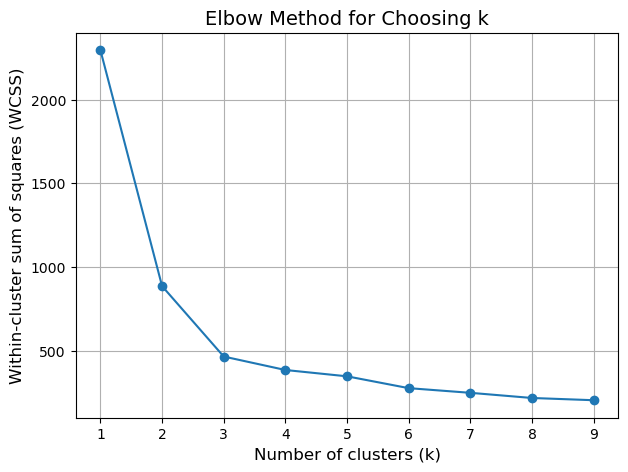

In [16]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 10)  # try k from 1 to 9

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

plt.figure(figsize=(7,5))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method for Choosing k')
plt.grid(True)
plt.savefig("elbow_plot_mes_kessler.pdf", format='pdf', bbox_inches='tight')
plt.savefig("elbow_plot_mes_kessler.svg", format='svg', bbox_inches='tight')
plt.show()


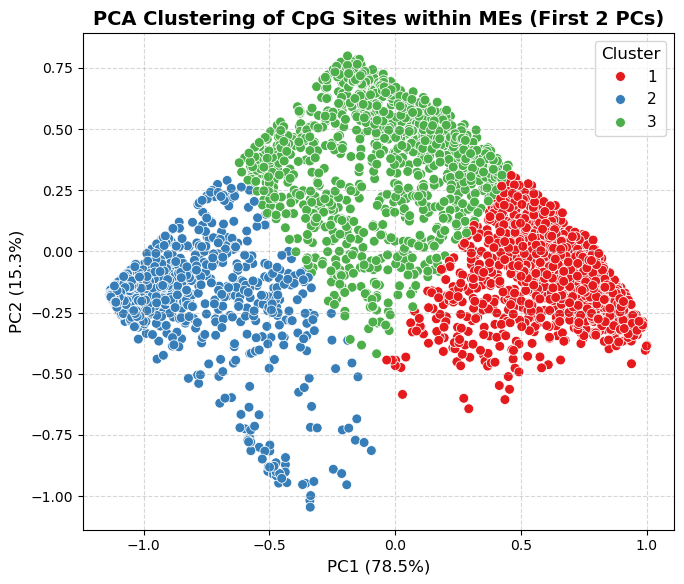

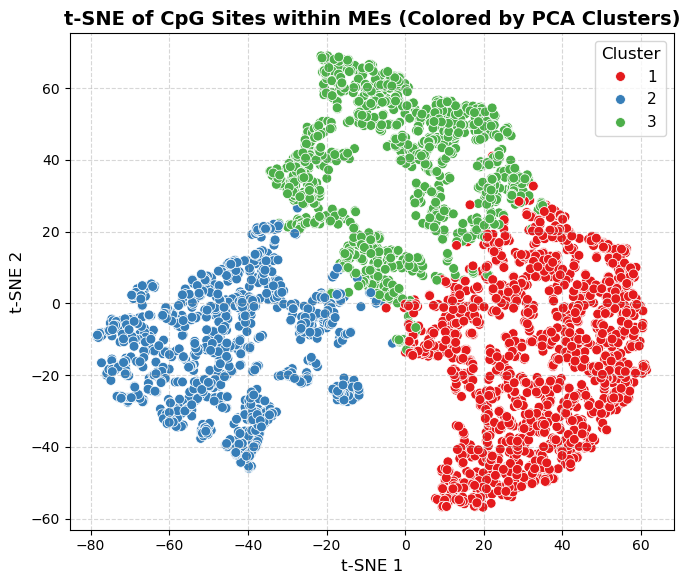

In [18]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv("cpgs_with_ME_ID.tsv", sep="\t")

# Select methylation fraction columns
frac_cols = [col for col in df.columns if col.endswith('_frac')]

# Filter rows with no NaNs in methylation fractions
X = df[frac_cols].dropna()

# Remove rows where all fraction values are zero
nonzero_mask = (X.sum(axis=1) > 0)  # sums > 0 means not all zeros
X_filtered = X.loc[nonzero_mask]

# Run PCA with 2 components on filtered data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered)

# KMeans clustering with 3 clusters on PCA result
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
cluster_labels_named = cluster_labels + 1  # rename clusters as 1,2,3

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# PCA scatter plot colored by clusters
plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=cluster_labels_named, palette='Set1', s=50
)
plt.title('PCA Clustering of CpG Sites within MEs (First 2 PCs)', weight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("pca_clustering_mes_kessler.pdf", bbox_inches='tight')
plt.savefig("pca_clustering_mes_kessler.svg", bbox_inches='tight')
plt.show()

# Run t-SNE (2D) on filtered data
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_filtered)

# t-SNE scatter plot colored by PCA clusters
plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=cluster_labels_named, palette='Set1', s=50
)
plt.title('t-SNE of CpG Sites within MEs (Colored by PCA Clusters)', weight='bold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("tsne_clustering_mes_kessler.pdf", bbox_inches='tight')
plt.savefig("tsne_clustering_mes_kessler.svg", bbox_inches='tight')
plt.show()


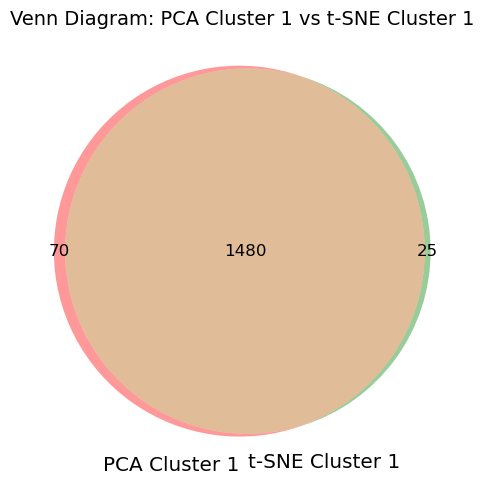

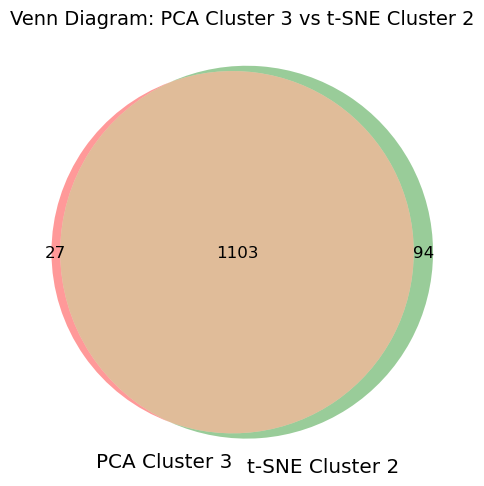

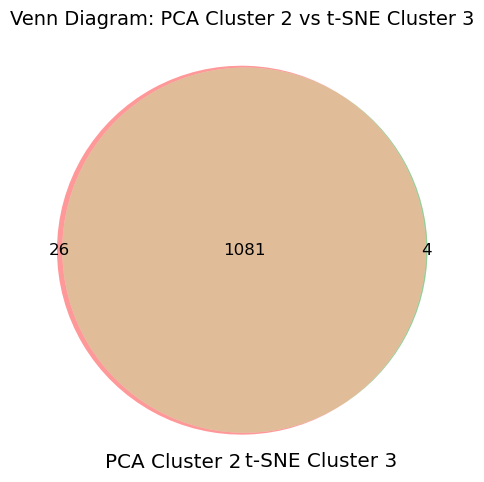

In [25]:
from matplotlib_venn import venn2

# Load your data
df = pd.read_csv("cpgs_with_ME_ID.tsv", sep="\t")

# Select methylation fraction columns
frac_cols = [col for col in df.columns if col.endswith('_frac')]

# Filter: drop rows with NaN and remove rows with all zeros
X = df[frac_cols].dropna()
nonzero_mask = (X.sum(axis=1) > 0)
X_filtered = X.loc[nonzero_mask]

# PCA on filtered data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered)

# KMeans clustering on PCA components
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
cluster_labels_named = cluster_labels + 1  # Rename clusters 1,2,3

# t-SNE on filtered data
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_filtered)

# KMeans clustering on t-SNE embeddings
kmeans_tsne = KMeans(n_clusters=3, random_state=42)
tsne_cluster_labels = kmeans_tsne.fit_predict(X_tsne)
tsne_cluster_labels_named = tsne_cluster_labels + 1

# Use indices from filtered data
indices = X_filtered.index

# Define cluster pairs to compare
pairs = [
    (1, 1),  # PCA 1 vs t-SNE 1
    (3, 2),  # PCA 3 vs t-SNE 2
    (2, 3),  # PCA 2 vs t-SNE 3
]

# Plot and save Venn diagrams for each pair
for i, (pca_c, tsne_c) in enumerate(pairs, 1):
    pca_set = set(indices[cluster_labels_named == pca_c])
    tsne_set = set(indices[tsne_cluster_labels_named == tsne_c])

    plt.figure(figsize=(5,5))
    venn2(
        [pca_set, tsne_set],
        set_labels=(f'PCA Cluster {pca_c}', f't-SNE Cluster {tsne_c}')
    )
    plt.title(f'Venn Diagram: PCA Cluster {pca_c} vs t-SNE Cluster {tsne_c}')
    plt.tight_layout()
    plt.savefig(f'venn_pca{pca_c}_tsne{tsne_c}.pdf', bbox_inches='tight')
    plt.savefig(f'venn_pca{pca_c}_tsne{tsne_c}.svg', bbox_inches='tight')
    plt.show()


/data/cephfs-1/home/users/cama15_c/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


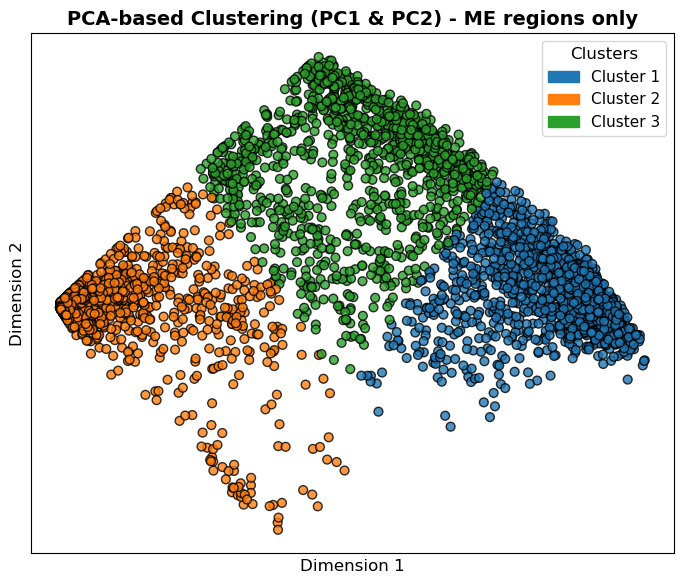

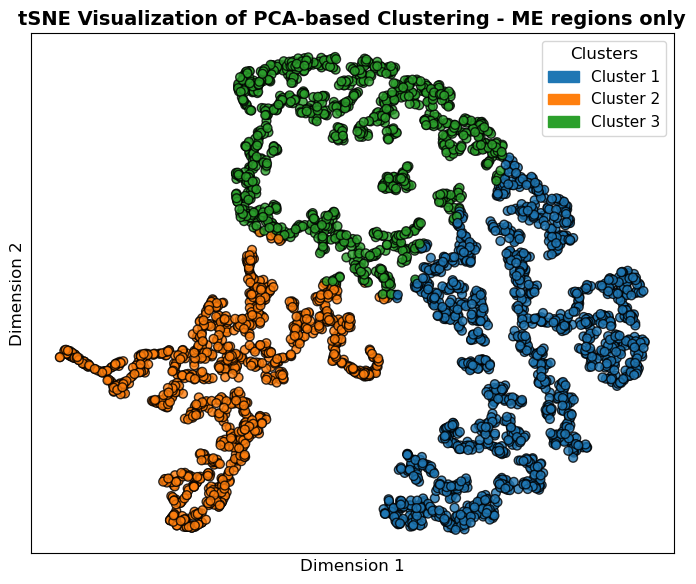

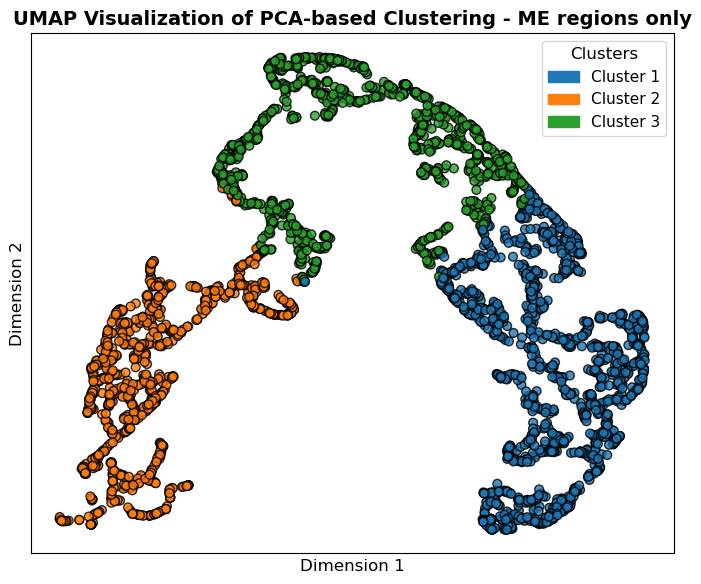

<Figure size 640x480 with 0 Axes>

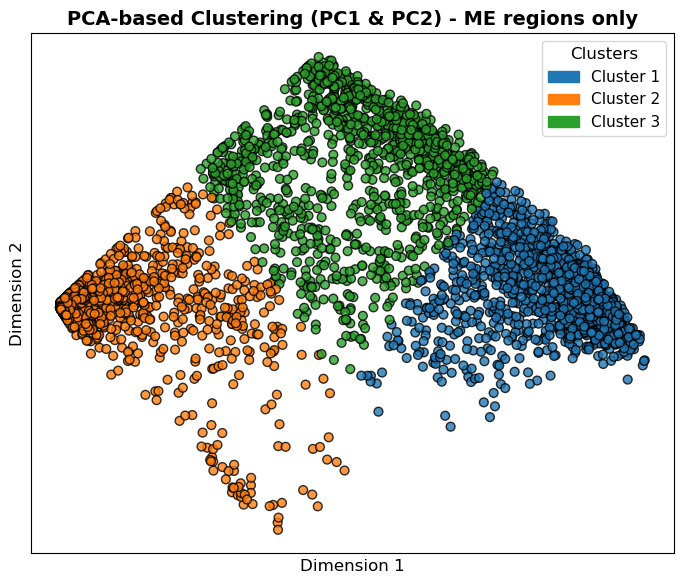

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

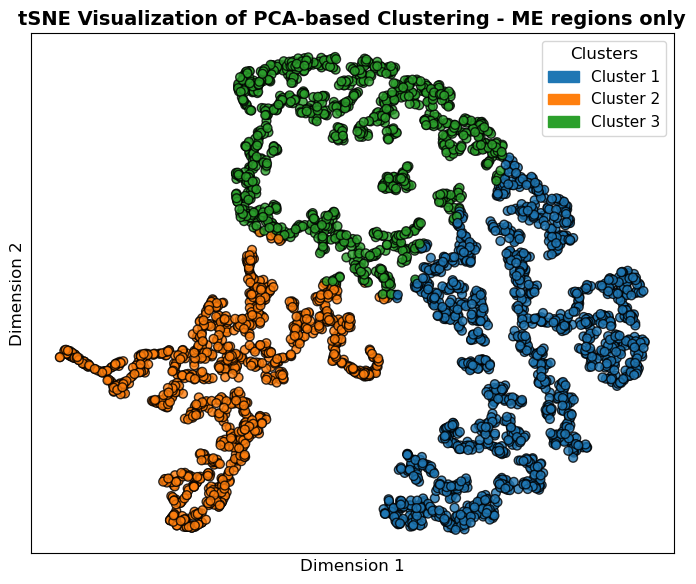

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

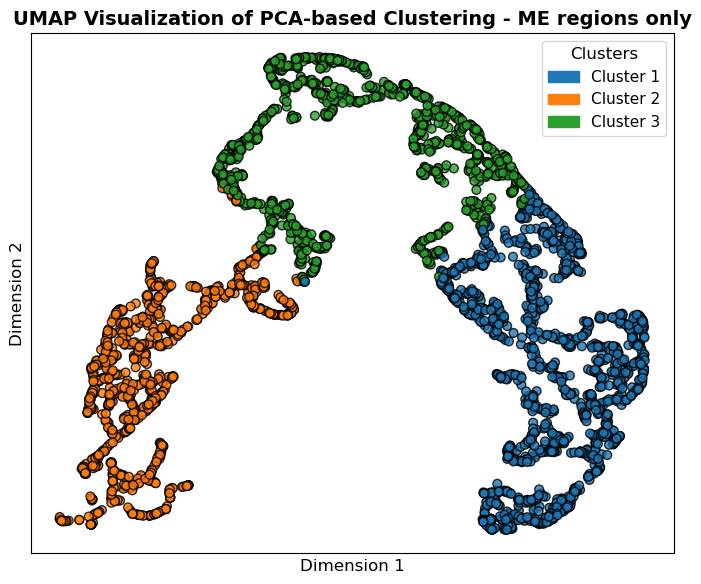

<Figure size 640x480 with 0 Axes>

In [28]:
import umap.umap_ as umap
import matplotlib.patches as mpatches

# Load data
df = pd.read_csv("cpgs_with_ME_ID.tsv", sep="\t")

# Keep only rows with non-null ME_ID
df_me = df[df['ME_ID'].notna()]

# Extract methylation fraction columns
frac_cols = [col for col in df_me.columns if col.endswith('_frac')]
X_me = df_me[frac_cols]

# Drop rows with any NaNs
X_me = X_me.dropna()

# Remove rows where all methylation fractions are zero
nonzero_mask = X_me.sum(axis=1) > 0
X_me_filtered = X_me[nonzero_mask]

# PCA (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_me_filtered)

# KMeans clustering (3 clusters)
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)
clusters_named = clusters_pca + 1  # clusters 1, 2, 3

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

# UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Plotting function
def plot_clusters(X_embedded, labels, title):
    plt.figure(figsize=(7, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    label_colors = [colors[label - 1] for label in labels]  # adjust for 1-based labels

    plt.scatter(
        X_embedded[:, 0],
        X_embedded[:, 1],
        c=label_colors,
        s=40,
        alpha=0.8,
        edgecolor='k'
    )
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(3)]
    plt.legend(handles=patches, title='Clusters', fontsize=11, title_fontsize=12, loc='best')
    plt.tight_layout()
    
    plt.show()

# Visualizations
plot_clusters(X_pca, clusters_named, 'PCA-based Clustering (PC1 & PC2) - ME regions only')
plot_clusters(X_tsne, clusters_named, 'tSNE Visualization of PCA-based Clustering - ME regions only')
plot_clusters(X_umap, clusters_named, 'UMAP Visualization of PCA-based Clustering - ME regions only')


/data/cephfs-1/home/users/cama15_c/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


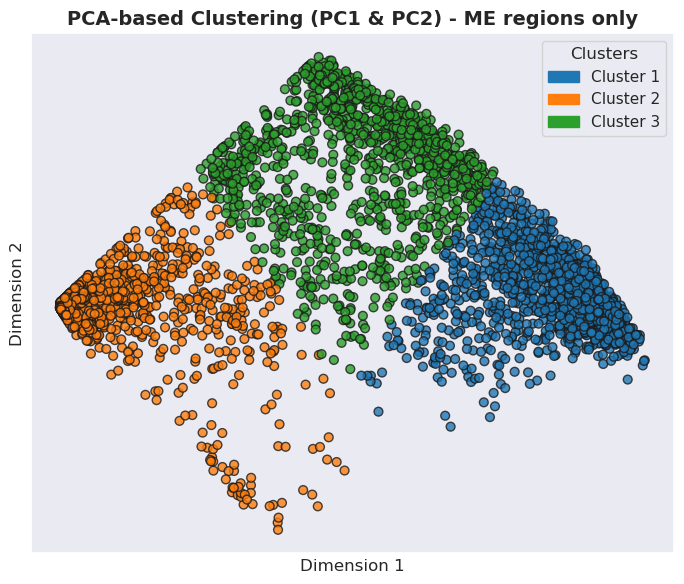

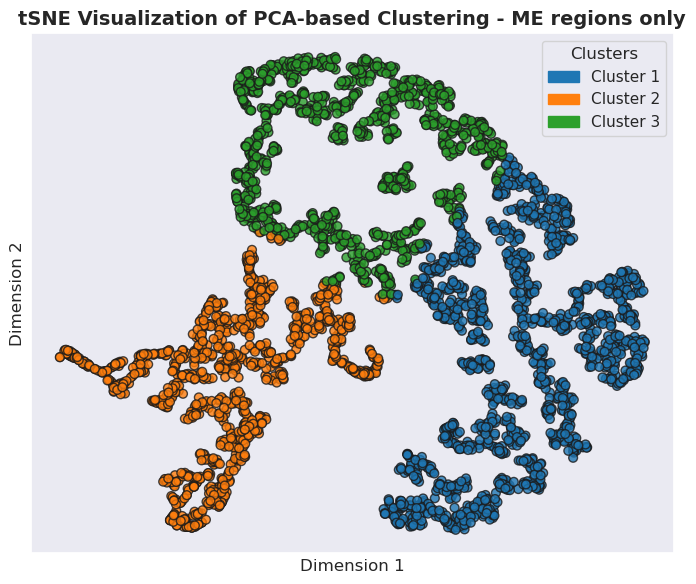

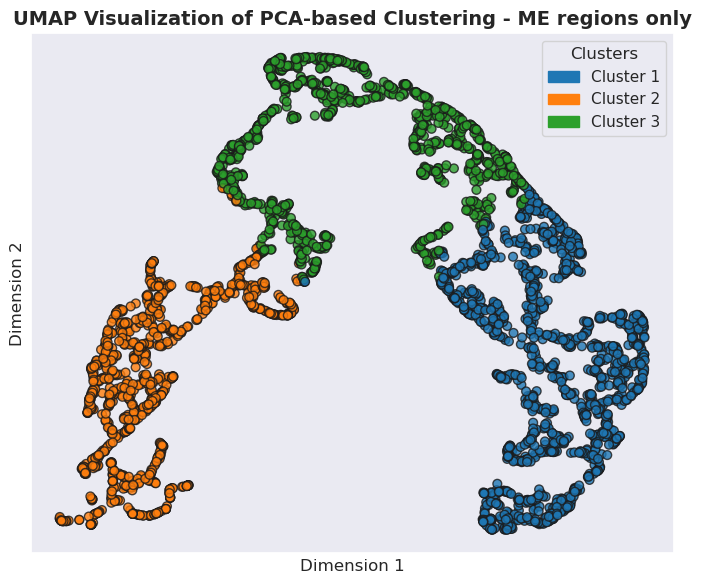

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Load data
df = pd.read_csv("cpgs_with_ME_ID.tsv", sep="\t")

# Keep only rows with non-null ME_ID
df_me = df[df['ME_ID'].notna()]

# Extract methylation fraction columns
frac_cols = [col for col in df_me.columns if col.endswith('_frac')]
X_me = df_me[frac_cols]

# Drop rows with any NaNs
X_me = X_me.dropna()

# Remove rows where all methylation fractions are zero
nonzero_mask = X_me.sum(axis=1) > 0
X_me_filtered = X_me[nonzero_mask]

# PCA (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_me_filtered)

# KMeans clustering (3 clusters)
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)
clusters_named = clusters_pca + 1  # clusters 1, 2, 3

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

# UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

def plot_clusters(X_embedded, labels, title, base_filename):
    plt.figure(figsize=(7, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    label_colors = [colors[label - 1] for label in labels]  # 1-based labels

    plt.scatter(
        X_embedded[:, 0],
        X_embedded[:, 1],
        c=label_colors,
        s=40,
        alpha=0.8,
        edgecolor='k'
    )
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(3)]
    plt.legend(handles=patches, title='Clusters', fontsize=11, title_fontsize=12, loc='best')
    plt.tight_layout()

    # Save as PDF and SVG
    plt.savefig(base_filename + '.pdf')
    plt.savefig(base_filename + '.svg')
    plt.show()
    plt.close()

# Visualizations with saving
plot_clusters(X_pca, clusters_named, 'PCA-based Clustering (PC1 & PC2) - ME regions only', 'PCA_clustering_ME')
plot_clusters(X_tsne, clusters_named, 'tSNE Visualization of PCA-based Clustering - ME regions only', 'tSNE_clustering_ME')
plot_clusters(X_umap, clusters_named, 'UMAP Visualization of PCA-based Clustering - ME regions only', 'UMAP_clustering_ME')

In [29]:
# Keep original rows that matched X_me_filtered (after NaN + zero removal)
df_me_filtered = df_me.loc[X_me_filtered.index].copy()

# Add PCA cluster labels
df_me_filtered['Cluster'] = clusters_named  # clusters 1, 2, 3

# Group rows by cluster and extract Chr, Start, End
regions_per_cluster = {}

for cluster_id, group in df_me_filtered.groupby('Cluster'):
    regions = group[['Chr', 'Start', 'End']].to_dict(orient='records')
    regions_per_cluster[cluster_id] = regions

In [33]:
# Sort by Cluster and then save to CSV
df_me_filtered.sort_values(by='Cluster').to_csv(
    'cpgs_clusters_regions_MEs_kessler.csv', #used to be called clusters_region_2
    columns=['Chr', 'Start', 'End', 'ME_ID', 'Cluster'],
    index=False
)

In [36]:
import pyranges as pr
import gzip

# Load CpGs
df_cpgs = pd.read_csv("cpgs_clusters_regions_MEs_kessler.csv")
df_cpgs = df_cpgs.rename(columns={"Chr": "Chromosome"})
df_cpgs["Chromosome"] = df_cpgs["Chromosome"].astype(str)
df_cpgs["Start"] = df_cpgs["Start"].astype(int)
df_cpgs["End"] = df_cpgs["End"].astype(int)
gr_cpgs = pr.PyRanges(df_cpgs[["Chromosome", "Start", "End"]])

# Annotate overlaps with BED files
bed_files = {
    "TSS": "gencode_v48_TSSs.bed",
    "Promoter": "gencode_v48_promoters.bed",
    "GeneBody": "gencode_v48_gene_bodies.bed",
    "Exon": "gencode_v48_exons.bed",
    "Intron": "gencode_v48_introns.bed"
}

for feature_name, bed_file in bed_files.items():
    gr_feature = pr.read_bed(bed_file)
    
    # Expand TSS by ±1000 bp
    if feature_name == "TSS":
        df_feat = gr_feature.df.copy()
        df_feat["Start"] = df_feat["Start"] - 1000
        df_feat["End"] = df_feat["End"] + 1000
        gr_feature = pr.PyRanges(df_feat)
    
    overlaps = gr_cpgs.overlap(gr_feature)
    overlapped_intervals = set(zip(overlaps.df["Chromosome"], overlaps.df["Start"], overlaps.df["End"]))
    
    def check_overlap(row):
        return (row["Chromosome"], row["Start"], row["End"]) in overlapped_intervals
    
    df_cpgs[f"Overlaps_{feature_name}"] = df_cpgs.apply(check_overlap, axis=1)

# Annotate GeneBody_Type and Gene_Name based on GTF
gtf_file = "gencode.v48.basic.annotation.gtf.gz"
gtf_cols = ["Chromosome", "Source", "Feature", "Start", "End", "Score", "Strand", "Frame", "Attributes"]

with gzip.open(gtf_file, "rt") as f:
    gtf = pd.read_csv(f, sep="\t", comment="#", names=gtf_cols)

genes = gtf[gtf["Feature"] == "gene"].copy()
genes["gene_type"] = genes["Attributes"].str.extract(r'gene_type "([^"]+)"')
genes["gene_id"] = genes["Attributes"].str.extract(r'gene_id "([^"]+)"')
genes["gene_name"] = genes["Attributes"].str.extract(r'gene_name "([^"]+)"')

target_types = ["protein_coding", "lncRNA", "pseudogene", "miRNA"]
genes_filtered = genes[genes["gene_type"].isin(target_types)].copy()

gr_genes_filtered = pr.PyRanges(genes_filtered[["Chromosome", "Start", "End", "gene_type", "gene_id", "gene_name"]])
gr_gene_overlap = gr_cpgs.join(gr_genes_filtered)

overlap_df = gr_gene_overlap.df[["Chromosome", "Start", "End", "gene_type", "gene_name"]].drop_duplicates()
overlap_df.rename(columns={"gene_type": "GeneBody_Type", "gene_name": "Gene_Name"}, inplace=True)

df_cpgs = df_cpgs.merge(overlap_df, on=["Chromosome", "Start", "End"], how="left")
df_cpgs["GeneBody_Type"] = df_cpgs["GeneBody_Type"].fillna("None")
df_cpgs["Gene_Name"] = df_cpgs["Gene_Name"].fillna("None")

# Annotate distances to retrotransposons
rmsk_file = "rmsk.txt.gz"
rmsk_cols = ["bin", "swScore", "milliDiv", "milliDel", "milliIns",
             "genoName", "genoStart", "genoEnd", "genoLeft",
             "strand", "repName", "repClass", "repFamily",
             "repStart", "repEnd", "repLeft", "id"]

rmsk = pd.read_csv(rmsk_file, sep="\t", names=rmsk_cols, header=None, compression='gzip')

repeat_types = {
    "Alu": rmsk[rmsk["repName"].str.contains("Alu")],
    "L1": rmsk[rmsk["repName"].str.contains("L1")],
    "SVA": rmsk[rmsk["repName"].str.contains("SVA")],
    "MIR": rmsk[rmsk["repName"].str.contains("MIR")],
    "LTR": rmsk[rmsk["repClass"].str.contains("LTR")]
}

pr_repeats = {}
for rep_type, df_rep in repeat_types.items():
    df_rep_rename = df_rep.rename(columns={"genoName": "Chromosome",
                                           "genoStart": "Start",
                                           "genoEnd": "End"})
    pr_repeats[rep_type] = pr.PyRanges(df_rep_rename[["Chromosome", "Start", "End"]])

for rep_type, gr_rep in pr_repeats.items():
    nearest = gr_cpgs.nearest(gr_rep)
    df_dist = nearest.df[["Chromosome", "Start", "End", "Distance"]].rename(columns={"Distance": f"Dist_to_{rep_type}"})
    df_cpgs = df_cpgs.merge(df_dist, on=["Chromosome", "Start", "End"], how="left")
    df_cpgs[f"Near_{rep_type}"] = df_cpgs[f"Dist_to_{rep_type}"].fillna(10**9) <= 1000

# Save final annotated CpG dataframe
df_cpgs = df_cpgs.sort_values(by="Cluster")
df_cpgs.to_csv("annotated_mes_kessler_clusters.csv", index=False)

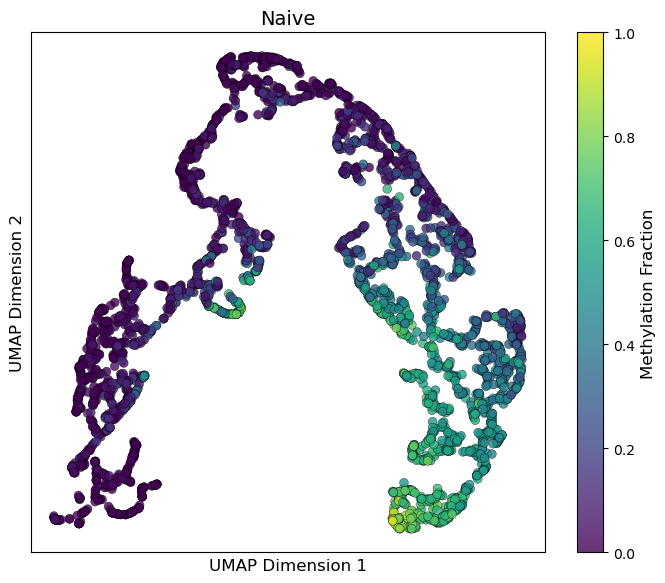

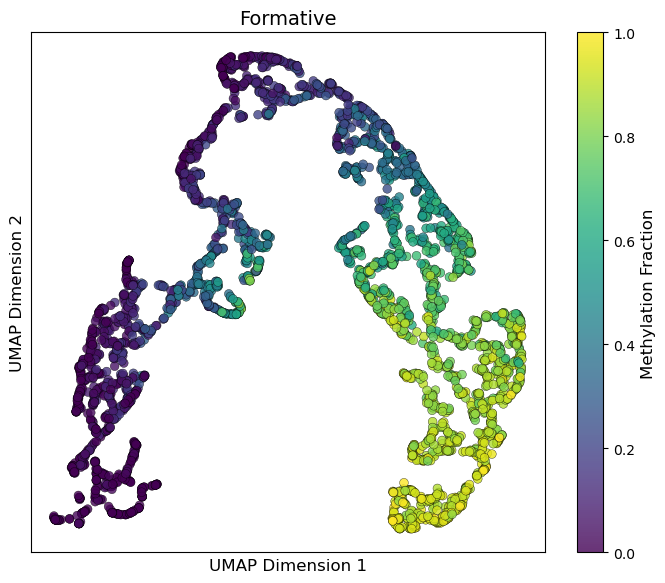

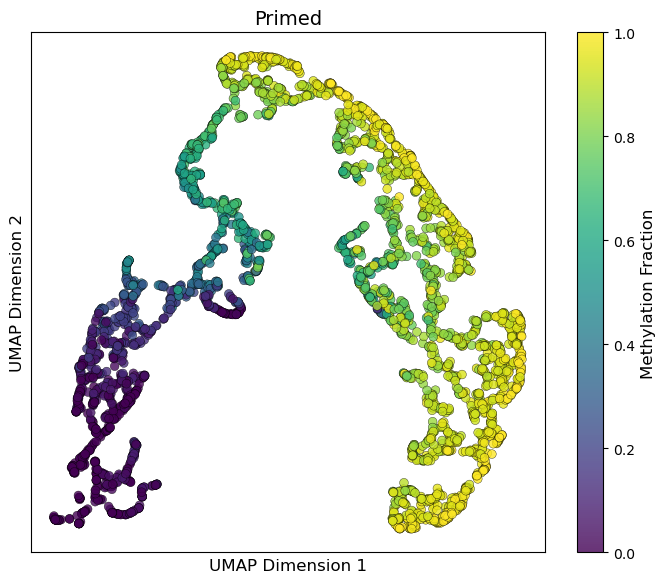

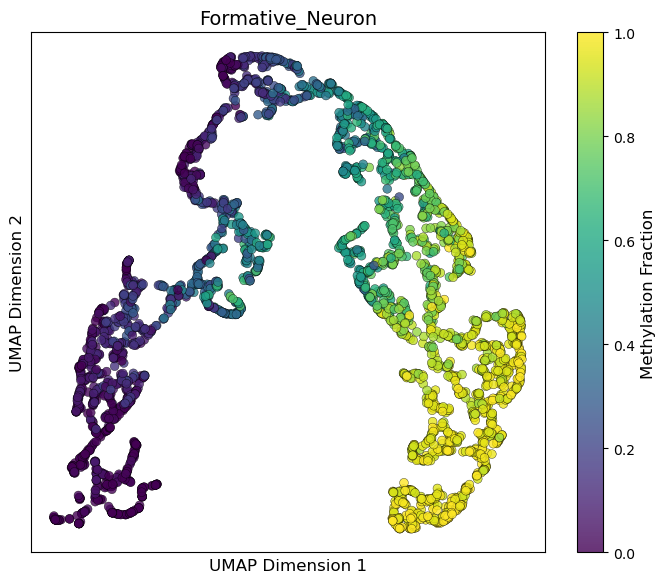

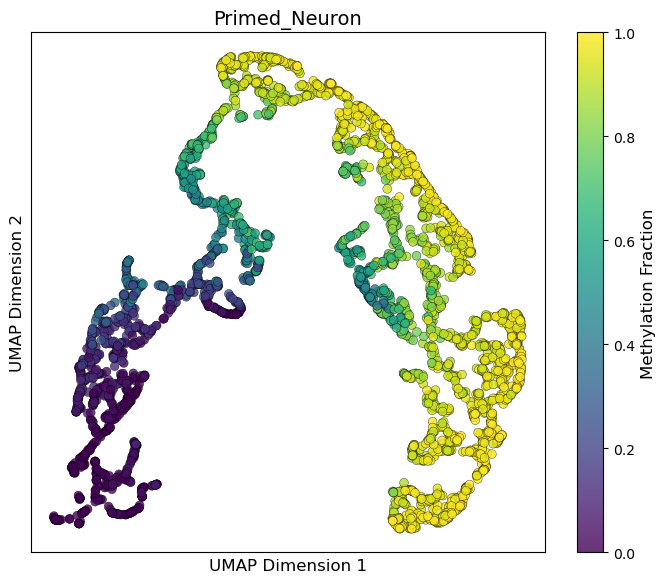

In [44]:
# Select columns ending with '_frac' for methylation fractions
sample_frac_cols = [col for col in X_me_filtered.columns if col.endswith('_frac')]

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

for i, sample_col in enumerate(sample_frac_cols, start=1):
    plt.figure(figsize=(7,6))
    
    methylation_vals = X_me_filtered[sample_col].values
    
    sc = plt.scatter(
        X_umap[:, 0], 
        X_umap[:, 1], 
        c=methylation_vals,
        cmap='viridis',
        s=40,
        alpha=0.8,
        edgecolor='k',
        linewidth=0.3
    )
    
    # Remove '_frac' suffix for cleaner titles and filenames
    sample_name = sample_col.replace('_frac', '')
    
    plt.title(f'{sample_name}', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(sc, label='Methylation Fraction')
    plt.tight_layout()
    
    pdf_fname = f'umap_methylation_{sample_name}.pdf'
    svg_fname = f'umap_methylation_{sample_name}.svg'
    plt.savefig(pdf_fname, bbox_inches='tight')
    plt.savefig(svg_fname, bbox_inches='tight')
    
    plt.show()

In [39]:
print(len(X_umap))  # should be 3787 here
print(len(X_me_filtered))  # should also be 3787


3787
3787


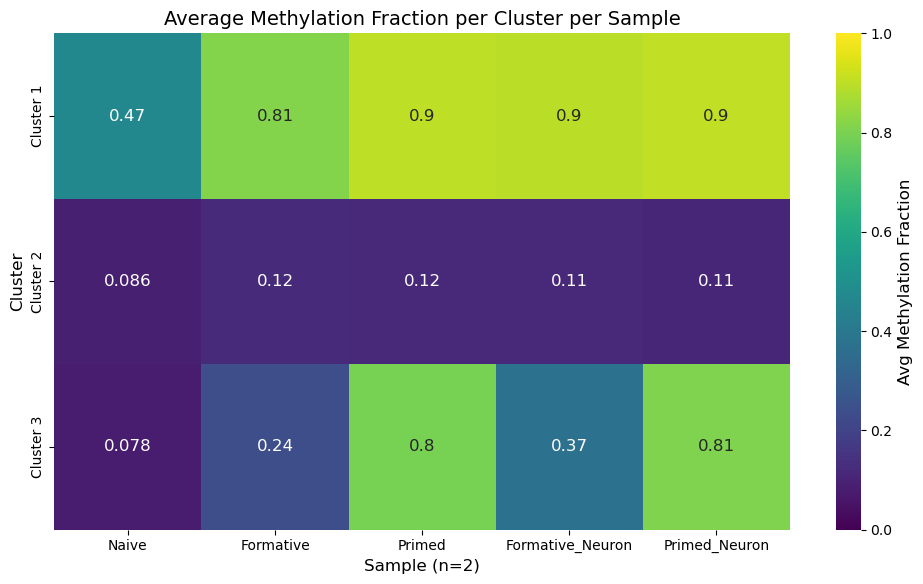

In [52]:
# Convert cluster labels into a DataFrame to align with X_me_filtered index
clusters_df = pd.DataFrame({'Cluster': clusters_named}, index=X_me_filtered.index)

# Combine cluster info and methylation data
df_combined = pd.concat([X_me_filtered, clusters_df], axis=1)

# Group by cluster, calculate mean methylation fraction per sample
cluster_means = df_combined.groupby('Cluster').mean()

# Optional: rename index to Cluster 1, Cluster 2, etc.
cluster_means.index = [f'Cluster {i}' for i in cluster_means.index]

# Rename columns to remove '_frac' suffix
cluster_means_renamed = cluster_means.rename(columns=lambda x: x.replace('_frac', ''))

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_means_renamed,
    annot=True,
    cmap='viridis',
    cbar_kws={'label': 'Avg Methylation Fraction'},
    vmin=0,
    vmax=1
)
plt.title('Average Methylation Fraction per Cluster per Sample')
plt.ylabel('Cluster')
plt.xlabel('Sample (n=2)')
plt.tight_layout()
plt.savefig("me_clusters_heatmap_kessler.pdf", format='pdf', bbox_inches='tight')  
plt.savefig("me_clusters_heatmap_kessler.svg", format='svg', bbox_inches='tight') 
plt.show()


In [61]:
print(df_me_filtered.columns)

Index(['Chr', 'Start', 'End', 'Naive_frac', 'Formative_frac', 'Primed_frac',
       'Formative_Neuron_frac', 'Primed_Neuron_frac', 'ME_ID'],
      dtype='object')


In [3]:
# Load annotation (contains ME_ID, Gene_Name, and Cluster)
annot_df = pd.read_csv("annotated_mes_kessler_clusters.csv", sep=",")

# Ensure Cluster column is numeric for proper sorting
annot_df['Cluster'] = pd.to_numeric(annot_df['Cluster'], errors='coerce')

# Drop rows with missing ME_ID or Cluster
annot_df = annot_df.dropna(subset=['ME_ID', 'Cluster'])

# Get ME_ID to Gene_Name and Cluster mapping
gene_map = annot_df[['ME_ID', 'Gene_Name']].drop_duplicates().fillna('None').groupby('ME_ID').first()
cluster_map = annot_df[['ME_ID', 'Cluster']].drop_duplicates().groupby('ME_ID').agg(lambda x: x.value_counts().idxmax())

# Combine cluster + gene info into a single map
gene_map['Cluster'] = cluster_map['Cluster']

# Align methylation data and assign ME_IDs
df_me_filtered = df_me.loc[X_me_filtered.index]
df_with_meid = X_me_filtered.copy()
df_with_meid['ME_ID'] = df_me_filtered['ME_ID']

# Group by ME_ID and compute average methylation fractions
sample_frac_cols = [col for col in df_with_meid.columns if col.endswith('_frac')]
cluster_means_me = df_with_meid.groupby('ME_ID')[sample_frac_cols].mean()
cluster_means_me.rename(columns=lambda x: x.replace('_frac', ''), inplace=True)

# Filter to ME_IDs in the annotation and order by cluster
cluster_means_me = cluster_means_me.loc[cluster_means_me.index.isin(gene_map.index)]
ordered_me_ids = gene_map.sort_values(by='Cluster').index

# Create labels: "ME_ID | Gene_Name"
combined_labels = [
    f"{me} | {gene_map.loc[me, 'Gene_Name']}" for me in ordered_me_ids
]

# Reorder matrix
heatmap_data = cluster_means_me.loc[ordered_me_ids]
heatmap_data.index = combined_labels

# Plot
plt.figure(figsize=(12, max(6, len(heatmap_data) * 0.3)))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Average Methylation Fraction'},
    vmin=0,
    vmax=1
)

plt.title('Average Methylation per ME_ID per Sample (Ordered by Cluster)')
plt.ylabel('ME_ID | Gene Name')
plt.xlabel('Sample')
plt.tight_layout()
plt.savefig("avg_methylation_per_MEID_cluster_ordered.pdf", bbox_inches='tight')
plt.savefig("avg_methylation_per_MEID_cluster_ordered.svg", bbox_inches='tight')
plt.show()


NameError: name 'df_me' is not defined

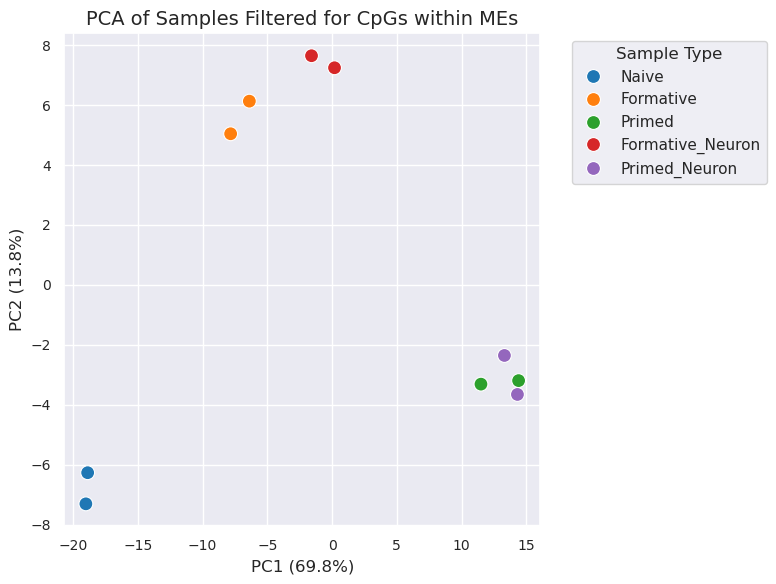

In [80]:
df = pd.read_csv('cpgs_within_metastable_epialleles.tsv', sep='\t')

# Extract fraction columns
frac_cols = [col for col in df.columns if col.endswith('_frac')]

frac_data = df[frac_cols]

# Get sample names like 'Naive_1', 'Primed_1', etc.
sample_names = [col.replace('_frac', '') for col in frac_cols]

# Transpose: samples as rows
frac_data_T = frac_data.T
frac_data_T.index = sample_names

# Fill missing values with column mean
frac_data_T = frac_data_T.fillna(frac_data_T.mean())

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(frac_data_T)

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})


# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Sample': sample_names
})

# Instead of splitting on the first underscore, split on last underscore:
plot_df['Sample_Type'] = plot_df['Sample'].apply(lambda x: '_'.join(x.split('_')[:-1]))

plt.figure(figsize=(8,6))

# Define a palette for sample types (add or adjust colors as you like)
palette = {
    'Naive': '#1f77b4',       # blue
    'Formative': '#ff7f0e',  # orange
    'Primed': '#2ca02c',     # green
    'Formative_Neuron': '#d62728',  # red
    'Primed_Neuron': '#9467bd'       # purple
}

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Sample_Type', s=100, palette=palette)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Samples Filtered for CpGs within MEs")
plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_mes_kessler.pdf", bbox_inches='tight')
plt.savefig("pca_mes_kessler.svg", bbox_inches='tight')
plt.show()
